<a href="https://colab.research.google.com/github/JellePiepenbrock/neurosmash/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
from IPython.display import clear_output
import os, sys

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/projects/entity_tagging/')

base_url = '/content//gdrive/My Drive/projects/NIPS/'

clear_output()

## Beta VAE

In [0]:
"""model.py"""

import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable


def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )

        model_parameters = filter(lambda p: p.requires_grad, self.encoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64),               # B, 256
            View((-1, 64, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 8, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(8, nc, 4, 2, 1),  # B, nc, 64, 64
        )

        model_parameters = filter(lambda p: p.requires_grad, self.decoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)


def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

Trainable parameters encoder:  395264
Trainable parameters encoder:  46595
Loaded model.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


torch.Size([14668, 2, 3, 64, 64]) torch.Size([14894, 3, 64, 64])
Epoch 1, loss 3.2277350425720215


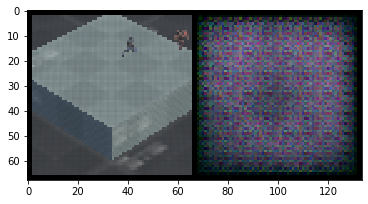

Epoch 2, loss 1.3971277475357056
Epoch 3, loss 1.0384852886199951
Epoch 4, loss 0.8028517365455627
Epoch 5, loss 0.7536361813545227
Epoch 6, loss 0.6225621700286865


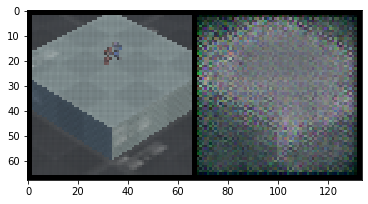

Epoch 7, loss 0.6777111291885376
Epoch 8, loss 0.6707649827003479
Epoch 9, loss 0.5733792185783386
Epoch 10, loss 0.4377155303955078
Epoch 11, loss 0.42627036571502686


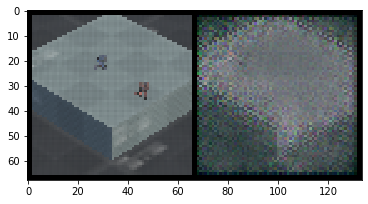

Epoch 12, loss 0.4297649562358856
Epoch 13, loss 0.39993733167648315
Epoch 14, loss 0.46536558866500854
Epoch 15, loss 0.42677778005599976
Epoch 16, loss 0.3669317364692688


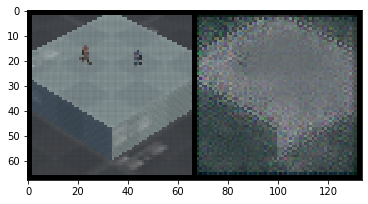

Epoch 17, loss 0.34990012645721436
Epoch 18, loss 0.36904630064964294
Epoch 19, loss 0.3459274470806122
Epoch 20, loss 0.2953634560108185
Epoch 21, loss 0.25213900208473206


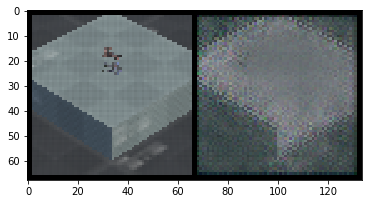

Epoch 22, loss 0.23073309659957886
Epoch 23, loss 0.25700560212135315
Epoch 24, loss 0.2570097744464874
Epoch 25, loss 0.2423814982175827
Epoch 26, loss 0.23016221821308136


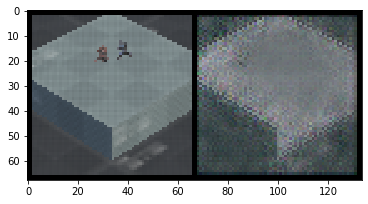

Epoch 27, loss 0.25088179111480713
Epoch 28, loss 0.21334604918956757
Epoch 29, loss 0.2178840935230255
Epoch 30, loss 0.1948496550321579
Epoch 31, loss 0.23444142937660217


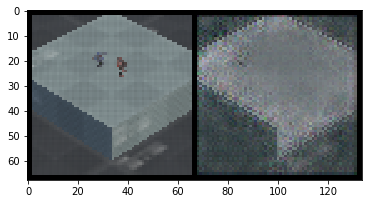

Epoch 32, loss 0.19345009326934814
Epoch 33, loss 0.20008233189582825
Epoch 34, loss 0.19249124825000763
Epoch 35, loss 0.1832152158021927
Epoch 36, loss 0.19995787739753723


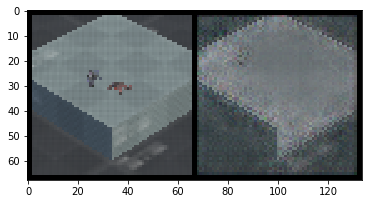

Epoch 37, loss 0.20296911895275116
Epoch 38, loss 0.20184776186943054
Epoch 39, loss 0.1739642173051834
Epoch 40, loss 0.21455250680446625
Epoch 41, loss 0.17988334596157074


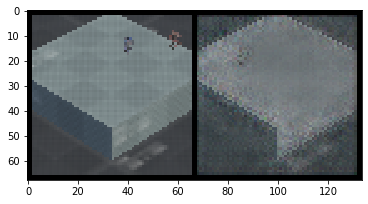

Epoch 42, loss 0.20288866758346558
Epoch 43, loss 0.16099385917186737
Epoch 44, loss 0.18321983516216278
Epoch 45, loss 0.19928039610385895
Epoch 46, loss 0.2121114730834961


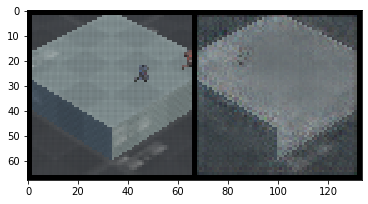

Epoch 47, loss 0.19537828862667084
Epoch 48, loss 0.19279855489730835
Epoch 49, loss 0.16586008667945862
Epoch 50, loss 0.15787553787231445
Epoch 51, loss 0.15788546204566956


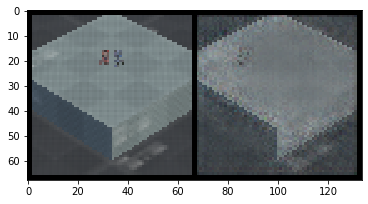

Epoch 52, loss 0.17108896374702454
Epoch 53, loss 0.18020543456077576
Epoch 54, loss 0.14565236866474152
Epoch 55, loss 0.22855599224567413
Epoch 56, loss 0.18149453401565552


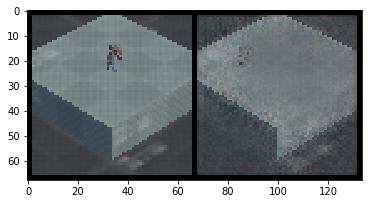

Epoch 57, loss 0.17727985978126526
Epoch 58, loss 0.1788894385099411
Epoch 59, loss 0.1922236979007721
Epoch 60, loss 0.1778070330619812
Epoch 61, loss 0.16230621933937073


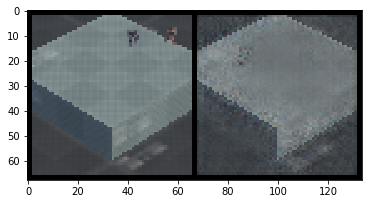

Epoch 62, loss 0.18725237250328064
Epoch 63, loss 0.17329096794128418
Epoch 64, loss 0.17070864140987396
Epoch 65, loss 0.19174911081790924
Epoch 66, loss 0.20267535746097565


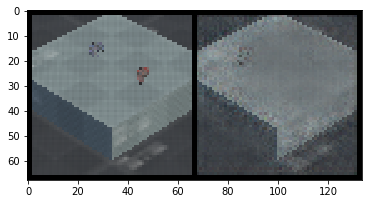

Epoch 67, loss 0.1746523380279541
Epoch 68, loss 0.2042400985956192
Epoch 69, loss 0.1609891951084137


KeyboardInterrupt: ignored

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform
import cv2

%matplotlib inline

from torchvision.utils import save_image
device = torch.device('cuda')

batch_size = 64

objective = 'H'
beta = 2
lr =  1e-4
z_dim =  32
max_iter =  1.5e6
decoder_dist = 'gaussian'

vae = BetaVAE_H(nc=3, z_dim=z_dim)
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr, betas=(0.9, 0.999))
print('Loaded model.')

# https://github.com/1Konny/Beta-VAE/blob/master/solver.py 

def mse_loss(input, target):
    return torch.sum((input - target) ** 2)

def weighted_mse_loss(input, target, weight):
    return torch.sum(weight * (input - target) ** 2)

def reconstruction_loss(x, x_recon, weights, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        # x_recon = F.sigmoid(x_recon)
        recon_loss = weighted_mse_loss(x_recon, x, weight=weights).sum() #F.mse_loss(x_recon, x, weights=weights, reduction='sum').div(batch_size)#, size_average=False).div(batch_size)
    else:
        recon_loss = None

    return recon_loss


def kl_divergence(mu, logvar):
    batch_size = mu.size(0)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld


def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

def max_rgb_filter(image):
	# split the image into its BGR components
	(R, G, B) = cv2.split(image)
 
	# find the maximum pixel intensity values for each
	# (x, y)-coordinate,, then set all pixel values less
	# than M to zero
	M = np.maximum(np.maximum(R, G), B)
	R[R < M] = 0
	G[G < M] = 0
	B[B < M] = 0
 
	# merge the channels back together and return the image
	return cv2.merge([R, G, B])
def main(episodes):
    dataset = None
    for i in range(1):
        if dataset is None:
            dataset = torch.load('{}/data/training_data_{}.pt'.format(base_url, i)) / 255
        else:
            dataset = torch.cat((dataset, torch.load('{}/data/training_data_{}.pt'.format(base_url, i)) / 255))
    
    test_dataset = torch.load('{}/data/training_data_{}.pt'.format(base_url, i+1)) / 255
    dataset = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset])  

    if mode == 'ext':
        dataset = [max_rgb_filter(np.uint8(x*255)) for x in dataset]
        dataset = np.transpose(dataset, (0, 3, 1, 2))
        dataset[:,0,:,:] *= 0
    elif mode == 'canny':
        filters = [cv2.Canny(np.uint8(x_*255*255), 100, 200) for x_ in dataset]
        dataset = np.array([cv2.bitwise_and(x_, x_, mask=f) for x_, f in zip(dataset, filters)])
        dataset = np.transpose(dataset, (0, 3, 1, 2))
    elif mode == 'filter':
        filters = np.repeat(np.array([np.array(cv2.Canny(np.uint8(x_*255*255), 100, 200)) for x_ in dataset]).reshape(-1, 1, 64, 64), 3, axis=1)
        dataset = np.transpose(dataset, (0, 3, 1, 2))
        dataset = np.array([np.array([x, f]) for x,f in zip(dataset, filters)])

    dataset = torch.from_numpy(dataset).float() #/ 255

    # dataset = dataset[:100]
    # # Divide by 255
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    epochs = 125
    print(dataset.shape, test_dataset.shape)
    for epoch in range(epochs):
        losses = [] 
        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()

            f = (batch[:,1,:,:,:].squeeze()).to(device)
            f[f == 0] = 0.05
            f[f == 255] = 10

            b = batch[:,0,:,:,:].squeeze().to(device)

            x_recon, mu, logvar = vae(b)
            recon_loss = reconstruction_loss(b, x_recon, f, decoder_dist)
            total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)

            loss = recon_loss + beta*total_kld
            # elif objective == 'B':
            #     C = torch.clamp(self.C_max/self.C_stop_iter*self.global_iter, 0, self.C_max.data[0])
            #     beta_vae_loss = recon_loss + self.gamma*(total_kld-C).abs()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch == 100:
            print('reducing lr')
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4
        print('Epoch {}, loss {}'.format(epoch+1, loss.item() / batch_size))
        if epoch % 5 == 0:
            fixed_x = b[randint(0, len(b)-1)].unsqueeze(0)
            compare_x = compare(fixed_x.to(device))
            
            # print(torch.stack(, compare_x).shape)
            save_image(compare_x.data.cpu(), '{}/neurosmash/images/sample_image_epoch_{}.png'.format(base_url, epoch))

            # Show final result. 
            img = mpimg.imread('{}/neurosmash/images/sample_image_epoch_{}.png'.format(base_url, epoch))
            imgplot = plt.imshow(img.squeeze())
            plt.show()
    
    print('Predicting test set:')
    for i, batch in enumerate(test_dataloader):
        if i > 10:
            break
        b = b.to(device)
        recon_images, mu, logvar = vae(b)

        fixed_x = b[randint(0, len(b)-1)].unsqueeze(0)
        compare_x = compare(fixed_x.to(device))
        
        save_image(compare_x.data.cpu(), '{}/neurosmash/images/sample_image_test_epoch_{}.png'.format(base_url, epoch))

        # Show final result. 
        img = mpimg.imread('{}/neurosmash/images/sample_image_test_epoch_{}.png'.format(base_url, epoch))
        imgplot = plt.imshow(img.squeeze())
        plt.show()

    # Store model. 
    torch.save(vae.state_dict(), 'b_vae.torch')
main(50)

## InfoVAE

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(3, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(32768, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 32768),
            torch.nn.ReLU(),
            Reshape((128,16,16,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 3, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import math
import matplotlib.pyplot as plt


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

%matplotlib inline
z_dim = 4
vae = Model(z_dim).to(device)#VAE(image_channels=3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
print('Loaded model.')

# https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
def compare(x):
    _, recon_x = vae(x)
    return torch.cat([x, recon_x])


def main(episodes):
    dataset = torch.load('{}/data/training_data_0.pt'.format(base_url)) #/ 255

    # Grayscale convertion.
    # dataset = [to_pil_image(x_) for x_ in dataset]
    # dataset = [to_grayscale(x_, 1) for x_ in dataset]
    # dataset = torch.stack([to_tensor(x_) for x_ in dataset])

    dataset = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset])

    filters = [cv2.Canny(np.uint8(x_*255), 100, 200) for x_ in dataset]
    dataset = np.array([cv2.bitwise_and(x_, x_, mask=f) for x_, f in zip(dataset, filters)])
    dataset = np.transpose(dataset, (0, 3, 1, 2))


    # Divide by 255
    dataset = torch.from_numpy(dataset) / 255
    dataloader = torch.utils.data.DataLoader(dataset[:100], batch_size=batch_size, shuffle=True)
    epochs = 10000
    for epoch in range(epochs):
        losses = [] 
        for i, b in enumerate(dataloader):
            optimizer.zero_grad()
            x = b.to(device)
            z, x_reconstructed = vae(x) 

            true_samples = torch.randn(200, z_dim, requires_grad=False).to(device)
            mmd = compute_mmd(true_samples, z)
            nll = (x_reconstructed - x).pow(2).sum()
            loss = nll + mmd*2
            loss.backward()
            optimizer.step()
        if (epoch % 500 == 0) or (epoch == epochs-1):
            # Store one image per epoch to showcase development of VAE.
            print('Epoch {} loss {}'.format(epoch, loss.item()))
            fixed_x = dataset[1].unsqueeze(0)
            compare_x = compare(fixed_x.to(device))
            save_image(compare_x.data.cpu(), '{}/neurosmash/images_infovae/sample_image_epoch_{}.png'.format(base_url, epoch+1))

        print('Epoch {}, loss {}'.format(epoch+1, loss.item()))
    # Store model. 
    torch.save(vae.state_dict(), '{}/vae.torch'.format(base_url))

    # Show final result. 
    img = mpimg.imread('{}/neurosmash/images_infovae/sample_image_epoch_{}.png'.format(base_url, epochs))
    imgplot = plt.imshow(img)
    plt.show()

main(50)

Loaded model.
Epoch 0 loss 3058.545166015625
Epoch 1, loss 3058.545166015625
Epoch 2, loss 502.080810546875
Epoch 3, loss 474.10992431640625
Epoch 4, loss 447.37835693359375
Epoch 5, loss 461.3016052246094
Epoch 6, loss 474.5263977050781
Epoch 7, loss 464.13616943359375
Epoch 8, loss 469.162109375
Epoch 9, loss 446.20269775390625
Epoch 10, loss 448.7720031738281
Epoch 11, loss 457.508056640625
Epoch 12, loss 470.95623779296875
Epoch 13, loss 462.3438720703125
Epoch 14, loss 466.48516845703125
Epoch 15, loss 458.5191650390625
Epoch 16, loss 471.57080078125
Epoch 17, loss 462.78289794921875
Epoch 18, loss 446.8538513183594
Epoch 19, loss 443.45538330078125
Epoch 20, loss 446.4017028808594
Epoch 21, loss 448.3352966308594
Epoch 22, loss 476.2066345214844
Epoch 23, loss 459.4753112792969
Epoch 24, loss 473.6770935058594
Epoch 25, loss 452.17608642578125
Epoch 26, loss 464.95428466796875
Epoch 27, loss 483.2177429199219
Epoch 28, loss 459.4775085449219
Epoch 29, loss 480.2716369628906
Epoch

KeyboardInterrupt: ignored

## VAE

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=32):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    # def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
    #     super(VAE, self).__init__()
    #     self.encoder = nn.Sequential(
    #         nn.Conv2d(image_channels, 4, kernel_size=4, stride=2),
    #         nn.ReLU(),
    #         nn.Conv2d(4, 4, kernel_size=4, stride=2),
    #         nn.ReLU(),
    #         nn.Conv2d(4, 4, kernel_size=4, stride=2),
    #         nn.ReLU(),
    #         nn.Conv2d(4, 4, kernel_size=4, stride=2),
    #         nn.ReLU(),
    #         Flatten()
    #     )
    #     self.fc1 = nn.Linear(h_dim, z_dim)
    #     self.fc2 = nn.Linear(h_dim, z_dim)
    #     self.fc3 = nn.Linear(z_dim, h_dim)
        
    #     self.decoder = nn.Sequential(
    #         UnFlatten(),
    #         nn.ConvTranspose2d(h_dim, 4, kernel_size=8, stride=2),
    #         nn.ReLU(),
    #         nn.ConvTranspose2d(4, 4, kernel_size=7, stride=2),
    #         nn.ReLU(),
    #         nn.ConvTranspose2d(4, 4, kernel_size=5, stride=2),
    #         nn.ReLU(),
    #         nn.ConvTranspose2d(4, 4, kernel_size=6, stride=2),
    #         nn.ReLU(),
    #         nn.ConvTranspose2d(4, 4, kernel_size=5, stride=2),
    #         nn.ReLU(),
    #         nn.ConvTranspose2d(4, 4, kernel_size=3, stride=2),
    #         nn.ReLU(),
    #         nn.ConvTranspose2d(4, image_channels, kernel_size=4, stride=2),
    #         nn.Sigmoid(),
    #     )
    def __init__(self, image_channels=3, h_dim=512, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        model_parameters = filter(lambda p: p.requires_grad, self.encoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, 32)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )

        model_parameters = filter(lambda p: p.requires_grad, self.decoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters decoder: ', params)
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

Trainable parameters encoder:  231200
Trainable parameters decoder:  43931
Loaded model.
torch.Size([14668, 2, 3, 64, 64]) torch.Size([14894, 3, 64, 64])
Epoch 1, loss 299.4956970214844


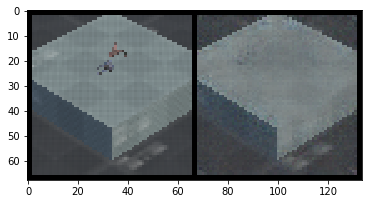

Epoch 2, loss 298.2204284667969
Epoch 3, loss 297.87249755859375
Epoch 4, loss 300.10382080078125
Epoch 5, loss 297.55029296875
Epoch 6, loss 297.2063293457031


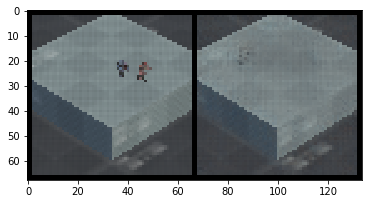

Epoch 7, loss 296.94232177734375


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
device = torch.device('cuda')

batch_size = 32

vae = VAE(image_channels=3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
print('Loaded model.')

mode = 'filter'

# https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb <-- source for code. 
def loss_fn(recon_x, x, vae_weights, mu, logvar):
    # Generate weights

    # Weighted BCE
    # vae_weights = torch.ones(1, 3, 64, 64).to(device)
    # vae_weights[:,0,:,:] *= 0.001
    # vae_weights *= 0.99
    # vae_weights = vae_weights.repeat(recon_x.shape[0], 1, 1, 1)
    
    BCE = F.binary_cross_entropy(recon_x, x, weight=vae_weights, reduction='sum')
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

def max_rgb_filter(image):
	(R, G, B) = cv2.split(image)
 
	# find the maximum pixel intensity values for each
	# (x, y)-coordinate,, then set all pixel values less
	# than M to zero
	M = np.maximum(np.maximum(R, G), B)
	R[R < M] = 0
	G[G < M] = 0
	B[B < M] = 0
 
	# merge the channels back together and return the image
	return cv2.merge([R, G, B])
 
def main(episodes):
    '''
    TODO:
    Assign weights based on distribution pixels.

    ADD Filters as weights, but set the zeros to 0.001 and ones to 0.99.

    Can also just use normal images, but with the CANNY edge detection as weights.
    
    '''
    dataset = None
    for i in range(1):
        if dataset is None:
            dataset = torch.load('{}/data/training_data_{}.pt'.format(base_url, i)) / 255
        else:
            dataset = torch.cat((dataset, torch.load('{}/data/training_data_{}.pt'.format(base_url, i)) / 255))
    
    test_dataset = torch.load('{}/data/training_data_{}.pt'.format(base_url, i+1)) / 255
    dataset = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset])  

    if mode == 'ext':
        dataset = [max_rgb_filter(np.uint8(x*255)) for x in dataset]
        dataset = np.transpose(dataset, (0, 3, 1, 2))
        dataset[:,0,:,:] *= 0
    elif mode == 'canny':
        filters = [cv2.Canny(np.uint8(x_*255*255), 100, 200) for x_ in dataset]
        dataset = np.array([cv2.bitwise_and(x_, x_, mask=f) for x_, f in zip(dataset, filters)])
        dataset = np.transpose(dataset, (0, 3, 1, 2))
    elif mode == 'filter':
        filters = np.repeat(np.array([np.array(cv2.Canny(np.uint8(x_*255*255), 100, 200)) for x_ in dataset]).reshape(-1, 1, 64, 64), 3, axis=1)
        dataset = np.transpose(dataset, (0, 3, 1, 2))
        dataset = np.array([np.array([x, f]) for x,f in zip(dataset, filters)])

    dataset = torch.from_numpy(dataset).float() #/ 255

    # dataset = dataset[:100]
    # # Divide by 255
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    epochs = 200
    print(dataset.shape, test_dataset.shape)
    for epoch in range(epochs):
        losses = [] 
        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()

            f = (batch[:,1,:,:,:].squeeze()).to(device)
            f[f == 0] = 0.05
            f[f == 255] = 0.95

            # torch.set_printoptions(profile="full")
            # print(f[0])
            # print('---')
            # torch.set_printoptions(profile="default")
            # break

            b = batch[:,0,:,:,:].squeeze().to(device)
            recon_images, mu, logvar = vae(b)
            
            loss, bce, kld = loss_fn(recon_images, b, f, mu, logvar)
            loss.backward()
            optimizer.step()

        if epoch == 100:
            print('reducing lr')
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4
        print('Epoch {}, loss {}'.format(epoch+1, loss.item() / batch_size))
        if epoch % 5 == 0:
            fixed_x = b[randint(0, len(b)-1)].unsqueeze(0)
            compare_x = compare(fixed_x.to(device))
            
            # print(torch.stack(, compare_x).shape)
            save_image(compare_x.data.cpu(), '{}/neurosmash/images/sample_image_epoch_{}.png'.format(base_url, epoch))

            # Show final result. 
            img = mpimg.imread('{}/neurosmash/images/sample_image_epoch_{}.png'.format(base_url, epoch))
            imgplot = plt.imshow(img.squeeze())
            plt.show()
    
    print('Predicting test set:')
    for i, batch in enumerate(test_dataloader):
        if i > 10:
            break
        b = b.to(device)
        recon_images, mu, logvar = vae(b)

        fixed_x = b[randint(0, len(b)-1)].unsqueeze(0)
        compare_x = compare(fixed_x.to(device))
        
        save_image(compare_x.data.cpu(), '{}/neurosmash/images/sample_image_test_epoch_{}.png'.format(base_url, epoch))

        # Show final result.
        img = mpimg.imread('{}/neurosmash/images/sample_image_test_epoch_{}.png'.format(base_url, epoch))
        imgplot = plt.imshow(img.squeeze())
        plt.show()

    # Store model.
    torch.save(vae.state_dict(), 'vae.torch')

main(50)

## VAE-GAN <-- wtf is even happening here..

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy
from torchvision.utils import save_image
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform


# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(3):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=8 * 8 * size, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size))
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//4))
        self.size = self.size//4
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 8, 8)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=8 * 8 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),

        )

    def forward(self, ten,other_ten,mode='REC'):
        if mode == "REC":
            ten = torch.cat((ten, other_ten), 0)
            for i, lay in enumerate(self.conv):
                # we take the 9th layer as one of the outputs
                if i == self.recon_levl:
                    ten, layer_ten = lay(ten, True)
                    # we need the layer representations just for the original and reconstructed,
                    # flatten, because it's a convolutional shape
                    layer_ten = layer_ten.view(len(layer_ten), -1)
                    return layer_ten
                else:
                    ten = lay(ten)
        else:
            ten = torch.cat((ten, other_ten), 0)
            for i, lay in enumerate(self.conv):
                    ten = lay(ten)

            ten = ten.view(len(ten), -1)
            ten = self.fc(ten)
            return F.sigmoid(ten)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=3,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/numpy.sqrt(numpy.prod(m.weight.shape[1:]))
                    scale /=numpy.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant(m.bias, 0.0)

    def forward(self, ten, gen_size=10):
        if self.training:
            # save the original images
            ten_original = ten
            # encode
            mus, log_variances = self.encoder(ten)
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            # sample from a gaussian

            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            # shift and scale using the means and variances

            ten = ten_from_normal * variances + mus
            # decode the tensor
            ten = self.decoder(ten)
            # discriminator for reconstruction
            ten_layer = self.discriminator(ten, ten_original, "REC")
            # decoder for samples

            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)

            ten = self.decoder(ten_from_normal)
            ten_class = self.discriminator(ten_original, ten, "GAN")
            return ten, ten_class, ten_layer, mus, log_variances
        else:
            if ten is None:
                # just sample and decode

                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                # we need the true variances, not the log one
                variances = torch.exp(log_variances * 0.5)
                # sample from a gaussian

                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                # shift and scale using the means and variances
                ten = ten_from_normal * variances + mus
                # decode the tensor
                ten = self.decoder(ten)
            return ten



    def __call__(self, *args, **kwargs):
        return super(VaeGan, self).__call__(*args, **kwargs)

    @staticmethod
    def loss(ten_original, ten_predict, layer_original, layer_predicted, labels_original,
             labels_sampled, mus, variances):
        """
        :param ten_original: original images
        :param ten_predict:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predict.view(len(ten_predict), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        # mse between intermediate layers
        mse = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1)
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original

        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)

        bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        '''
        
        bce_gen_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.ones_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_gen_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.ones_like(labels_sampled.data).cuda(), requires_grad=False))
        bce_dis_original = nn.BCEWithLogitsLoss(size_average=False)(labels_original,
                                        Variable(torch.ones_like(labels_original.data).cuda(), requires_grad=False))
        bce_dis_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.zeros_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_dis_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.zeros_like(labels_sampled.data).cuda(), requires_grad=False))
        '''
        return nle, kl, mse, bce_dis_original, bce_dis_sampled,bce_gen_original,bce_gen_sampled

In [0]:
# just a class to store a rolling average
# useful to log to TB
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [0]:
!pip install tensorboardX

In [0]:
import torch
import numpy
numpy.random.seed(8)
torch.manual_seed(8)
torch.cuda.manual_seed(8)
from torch.autograd import Variable
from torch.utils.data import Dataset
from tensorboardX import SummaryWriter
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
import progressbar
from torchvision.utils import make_grid


if __name__ == "__main__":

    train_folder = '{}/data/training_data_0.pt'.format(base_url)
    test_folder = '{}/data/training_data_1.pt'.format(base_url)
    z_size = 128#args.z_size
    recon_level = 3#args.recon_level
    decay_mse = 1#args.decay_mse
    decay_margin = 1#args.decay_margin
    n_epochs = 12#args.n_epochs
    lambda_mse = 1e-6#args.lambda_mse
    lr = 3e-4#args.lr
    decay_lr = 0.75#args.decay_lr
    decay_equilibrium = 1#args.decay_equilibrium
    slurm = False #args.slurm

    writer = SummaryWriter(comment="_CELEBA_NEW_DATA_STOCK_GAN")
    net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

    # train = torch.load(train_folder)

    # DATASET
    train = torch.load(train_folder)[:100]
    test = torch.load(test_folder)[:10]
    dataloader = torch.utils.data.DataLoader(train, batch_size=64,
                                                shuffle=True, num_workers=4)
    # DATASET for test
    # if you want to split train from test just move some files in another dir
    dataloader_test = torch.utils.data.DataLoader(test, batch_size=100,
                                                      shuffle=False, num_workers=1)

    #margin and equilibirum
    margin = 0.35
    equilibrium = 0.68
    #mse_lambda = 1.0
    # OPTIM-LOSS
    # an optimizer for each of the sub-networks, so we can selectively backprop
    #optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    #lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
    lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
    #optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
    #lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
    #optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)
    #lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)

    batch_number = len(dataloader)
    step_index = 0
    widgets = [

        'Batch: ', progressbar.Counter(),
        '/', progressbar.FormatCustomText('%(total)s', {"total": batch_number}),
        ' ', progressbar.Bar(marker="-", left='[', right=']'),
        ' ', progressbar.ETA(),
        ' ',
        progressbar.DynamicMessage('loss_nle'),
        ' ',
        progressbar.DynamicMessage('loss_encoder'),
        ' ',
        progressbar.DynamicMessage('loss_decoder'),
        ' ',
        progressbar.DynamicMessage('loss_discriminator'),
        ' ',
        progressbar.DynamicMessage('loss_mse_layer'),
        ' ',
        progressbar.DynamicMessage('loss_kld'),
        ' ',
        progressbar.DynamicMessage("epoch")
    ]
    # for each epoch
    if slurm:
        print(args)
    for i in range(n_epochs):
        print(i)

        progress = progressbar.ProgressBar(min_value=0, max_value=batch_number, initial_value=0,
                                           widgets=widgets).start()
        # reset rolling average
        loss_nle_mean = RollingMeasure()
        loss_encoder_mean = RollingMeasure()
        loss_decoder_mean = RollingMeasure()
        loss_discriminator_mean = RollingMeasure()
        loss_reconstruction_layer_mean = RollingMeasure()
        loss_kld_mean = RollingMeasure()
        gan_gen_eq_mean = RollingMeasure()
        gan_dis_eq_mean = RollingMeasure()
        print("LR:{}".format(lr_encoder.get_lr()))

        # for each batch
        for j, data_batch in enumerate(dataloader):
            data_batch = data_batch / 255
            target_batch = data_batch
            
            # set to train mode
            net.train()
            # target and input are the same images

            data_target = Variable(target_batch, requires_grad=False).float().cuda()
            data_in = Variable(data_batch, requires_grad=False).float().cuda()


            # get output
            out, out_labels, out_layer, mus, variances = net(data_in)
            # split so we can get the different parts
            out_layer_predicted = out_layer[:len(out_layer) // 2]
            out_layer_original = out_layer[len(out_layer) // 2:]
            # TODO set a batch_len variable to get a clean code here
            out_labels_original = out_labels[:len(out_labels) // 2]
            out_labels_sampled = out_labels[-len(out_labels) // 2:]
            # loss, nothing special here
            nle_value, kl_value, mse_value, bce_dis_original_value, bce_dis_sampled_value,\
                bce_gen_original_value,bce_gen_sampled_value= VaeGan.loss(data_target, out, out_layer_original,
                                                                         out_layer_predicted, out_labels_original,
                                                                          out_labels_sampled, mus,
                                                                         variances)
            # THIS IS THE MOST IMPORTANT PART OF THE CODE
            loss_encoder = torch.sum(kl_value)+torch.sum(mse_value)
            loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)
            loss_decoder = torch.sum(lambda_mse * mse_value) - (1.0 - lambda_mse) * loss_discriminator
            # register mean values of the losses for logging
            loss_nle_mean(torch.mean(nle_value).data.cpu().numpy())
            loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).data.cpu().numpy())
            loss_decoder_mean((torch.mean(lambda_mse * mse_value) - (1 - lambda_mse) * (torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value))).data.cpu().numpy())

            loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value)).data.cpu().numpy())
            loss_reconstruction_layer_mean(torch.mean(mse_value).data.cpu().numpy())
            loss_kld_mean(torch.mean(kl_value).data.cpu().numpy())
            # selectively disable the decoder of the discriminator if they are unbalanced
            train_dis = True
            train_dec = True
            if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                train_dis = False
            if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                train_dec = False
            if train_dec is False and train_dis is False:
                train_dis = True
                train_dec = True

            #aggiungo log
            if train_dis:
                gan_dis_eq_mean(1.0)
            else:
                gan_dis_eq_mean(0.0)

            if train_dec:
                gan_gen_eq_mean(1.0)
            else:
                gan_gen_eq_mean(0.0)

            # BACKPROP
            # clean grads
            net.zero_grad()
            # encoder
            loss_encoder.backward(retain_graph=True)
            # someone likes to clamp the grad here
            #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
            # update parameters
            optimizer_encoder.step()
            # clean others, so they are not afflicted by encoder loss
            net.zero_grad()
            #decoder
            if train_dec:
                loss_decoder.backward(retain_graph=True)
                #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                optimizer_decoder.step()
                #clean the discriminator
                net.discriminator.zero_grad()
            #discriminator
            if train_dis:
                loss_discriminator.backward()
                #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                optimizer_discriminator.step()

            # LOGGING
            # if  slurm:
            # progress.update(progress.value + 1, loss_nle=loss_nle_mean.measure,
            #                 loss_encoder=loss_encoder_mean.measure,
            #                 loss_decoder=loss_decoder_mean.measure,
            #                 loss_discriminator=loss_discriminator_mean.measure,
            #                 loss_mse_layer=loss_reconstruction_layer_mean.measure,
            #                 loss_kld=loss_kld_mean.measure,
            #                 epoch=i + 1)

        # EPOCH END
        progress.update(progress.value + 1, loss_nle=loss_nle_mean.measure,
                        loss_encoder=loss_encoder_mean.measure,
                        loss_decoder=loss_decoder_mean.measure,
                        loss_discriminator=loss_discriminator_mean.measure,
                        loss_mse_layer=loss_reconstruction_layer_mean.measure,
                        loss_kld=loss_kld_mean.measure,
                        epoch=i + 1)
        lr_encoder.step()
        lr_decoder.step()
        lr_discriminator.step()
        margin *=decay_margin
        equilibrium *=decay_equilibrium
        #margin non puo essere piu alto di equilibrium
        if margin > equilibrium:
            equilibrium = margin
        lambda_mse *=decay_mse
        if lambda_mse > 1:
            lambda_mse=1
        progress.finish()

        writer.add_scalar('loss_encoder', loss_encoder_mean.measure, step_index)
        writer.add_scalar('loss_decoder', loss_decoder_mean.measure, step_index)
        writer.add_scalar('loss_discriminator', loss_discriminator_mean.measure, step_index)
        writer.add_scalar('loss_reconstruction', loss_nle_mean.measure, step_index)
        writer.add_scalar('loss_kld',loss_kld_mean.measure,step_index)
        writer.add_scalar('gan_gen',gan_gen_eq_mean.measure,step_index)
        writer.add_scalar('gan_dis',gan_dis_eq_mean.measure,step_index)

    for j, data_batch in enumerate(dataloader_test):
        data_batch = data_batch / 255
        target_batch = data_batch
        net.eval()

        data_in = Variable(data_batch, requires_grad=False).float().cuda()
        data_target = Variable(target_batch, requires_grad=False).float().cuda()
        out = net(data_in)
        out = out.data.cpu()
        out = (out + 1) / 2
        out = make_grid(out, nrow=8)
        save_image(out.data.cpu(), '{}/neurosmash/images_gan/sample_image_epoch_{}_rec.png'.format(base_url, j))

        img = mpimg.imread('{}/neurosmash/images_gan/sample_image_epoch_{}_rec.png'.format(base_url, j))
        imgplot = plt.imshow(img)
        plt.show()
        # out = net(None, 100)
        # out = out.data.cpu()
        # out = (out + 1) / 2
        # out = make_grid(out, nrow=8)
        # writer.add_image("generated", out, step_index)

        out = data_target.data.cpu()
        out = (out + 1) / 2
        out = make_grid(out, nrow=8)
        save_image(out.data.cpu(), '{}/neurosmash/images_gan/sample_image_epoch_{}_orig.png'.format(base_url, j))
        break

        step_index += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:204: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:206: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

0
LR:[0.0003]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.154 loss_encoder: 2.63e+03 loss_decoder: -0.0816 loss_discriminator: 0.0842 loss_mse_layer: 2.62e+03 loss_kld:   7.96 epoch:      1
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

1
LR:[0.000225]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.143 loss_encoder: 2.66e+03 loss_decoder: -0.224 loss_discriminator:  0.227 loss_mse_layer: 2.65e+03 loss_kld:   9.25 epoch:      2
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

2
LR:[0.00016874999999999998]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.116 loss_encoder: 2.49e+03 loss_decoder: -0.912 loss_discriminator:  0.915 loss_mse_layer: 2.48e+03 loss_kld:   11.9 epoch:      3
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

3
LR:[0.0001265625]


Batch: 2/2 [] Time:  0:00:00 loss_nle:  0.102 loss_encoder: 1.72e+04 loss_decoder: -0.0812 loss_discriminator: 0.0983 loss_mse_layer: 1.72e+04 loss_kld:   11.8 epoch:      4
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

4
LR:[9.4921875e-05]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.101 loss_encoder: 1.62e+04 loss_decoder: -0.106 loss_discriminator:  0.122 loss_mse_layer: 1.62e+04 loss_kld:   16.9 epoch:      5
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

5
LR:[7.119140624999999e-05]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0991 loss_encoder: 1.51e+04 loss_decoder: -0.141 loss_discriminator:  0.157 loss_mse_layer: 1.51e+04 loss_kld:   26.7 epoch:      6
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

6
LR:[5.3393554687499995e-05]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0971 loss_encoder: 1.47e+04 loss_decoder: -0.195 loss_discriminator:  0.209 loss_mse_layer: 1.46e+04 loss_kld:   26.6 epoch:      7
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

7
LR:[4.0045166015624994e-05]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0943 loss_encoder: 1.43e+04 loss_decoder:  -0.25 loss_discriminator:  0.264 loss_mse_layer: 1.42e+04 loss_kld:   28.2 epoch:      8
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

8
LR:[3.003387451171875e-05]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.091 loss_encoder: 1.35e+04 loss_decoder: -0.298 loss_discriminator:  0.311 loss_mse_layer: 1.34e+04 loss_kld:   22.6 epoch:      9
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

9
LR:[2.252540588378906e-05]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.089 loss_encoder: 1.31e+04 loss_decoder: -0.365 loss_discriminator:  0.379 loss_mse_layer: 1.31e+04 loss_kld:   20.4 epoch:     10
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

10
LR:[1.6894054412841794e-05]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0877 loss_encoder: 1.27e+04 loss_decoder: -0.369 loss_discriminator:  0.381 loss_mse_layer: 1.27e+04 loss_kld:   20.1 epoch:     11
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

11
LR:[1.2670540809631346e-05]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0864 loss_encoder: 1.22e+04 loss_decoder: -0.422 loss_discriminator:  0.435 loss_mse_layer: 1.22e+04 loss_kld:   17.3 epoch:     12
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

12
LR:[9.50290560722351e-06]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0854 loss_encoder: 1.18e+04 loss_decoder: -0.424 loss_discriminator:  0.435 loss_mse_layer: 1.18e+04 loss_kld:     20 epoch:     13
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

13
LR:[7.127179205417632e-06]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0845 loss_encoder: 1.19e+04 loss_decoder: -0.474 loss_discriminator:  0.486 loss_mse_layer: 1.18e+04 loss_kld:   17.7 epoch:     14
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

14
LR:[5.3453844040632245e-06]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0848 loss_encoder: 1.17e+04 loss_decoder: -0.571 loss_discriminator:  0.583 loss_mse_layer: 1.17e+04 loss_kld:   18.3 epoch:     15
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

15
LR:[4.009038303047418e-06]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0845 loss_encoder: 1.18e+04 loss_decoder: -0.608 loss_discriminator:  0.619 loss_mse_layer: 1.18e+04 loss_kld:   17.9 epoch:     16
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

16
LR:[3.0067787272855638e-06]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0843 loss_encoder: 1.12e+04 loss_decoder: -0.589 loss_discriminator:    0.6 loss_mse_layer: 1.12e+04 loss_kld:   13.2 epoch:     17
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

17
LR:[2.2550840454641726e-06]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.13e+04 loss_decoder: -0.604 loss_discriminator:  0.616 loss_mse_layer: 1.13e+04 loss_kld:   18.4 epoch:     18
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

18
LR:[1.6913130340981295e-06]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.13e+04 loss_decoder: -0.557 loss_discriminator:  0.568 loss_mse_layer: 1.13e+04 loss_kld:   17.5 epoch:     19
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

19
LR:[1.268484775573597e-06]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.14e+04 loss_decoder: -0.603 loss_discriminator:  0.614 loss_mse_layer: 1.14e+04 loss_kld:   18.6 epoch:     20
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

20
LR:[9.513635816801979e-07]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.14e+04 loss_decoder: -0.597 loss_discriminator:  0.609 loss_mse_layer: 1.14e+04 loss_kld:   17.3 epoch:     21
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

21
LR:[7.135226862601484e-07]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.13e+04 loss_decoder: -0.602 loss_discriminator:  0.613 loss_mse_layer: 1.13e+04 loss_kld:   17.3 epoch:     22
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

22
LR:[5.351420146951114e-07]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.14e+04 loss_decoder: -0.581 loss_discriminator:  0.593 loss_mse_layer: 1.14e+04 loss_kld:   18.7 epoch:     23
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

23
LR:[4.0135651102133346e-07]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0842 loss_encoder: 1.16e+04 loss_decoder: -0.669 loss_discriminator:  0.681 loss_mse_layer: 1.16e+04 loss_kld:   16.8 epoch:     24
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

24
LR:[3.010173832660001e-07]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.14e+04 loss_decoder:  -0.59 loss_discriminator:  0.602 loss_mse_layer: 1.13e+04 loss_kld:   17.9 epoch:     25
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

25
LR:[2.257630374495001e-07]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0834 loss_encoder: 1.17e+04 loss_decoder: -0.595 loss_discriminator:  0.606 loss_mse_layer: 1.17e+04 loss_kld:   17.5 epoch:     26
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

26
LR:[1.6932227808712506e-07]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0842 loss_encoder: 1.16e+04 loss_decoder: -0.666 loss_discriminator:  0.677 loss_mse_layer: 1.15e+04 loss_kld:   17.8 epoch:     27
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

27
LR:[1.269917085653438e-07]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0841 loss_encoder: 1.14e+04 loss_decoder: -0.632 loss_discriminator:  0.643 loss_mse_layer: 1.14e+04 loss_kld:   17.9 epoch:     28
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

28
LR:[9.524378142400785e-08]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.12e+04 loss_decoder:  -0.64 loss_discriminator:  0.651 loss_mse_layer: 1.12e+04 loss_kld:   15.7 epoch:     29
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

29
LR:[7.143283606800588e-08]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.17e+04 loss_decoder: -0.563 loss_discriminator:  0.574 loss_mse_layer: 1.17e+04 loss_kld:     18 epoch:     30
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

30
LR:[5.357462705100441e-08]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.16e+04 loss_decoder: -0.655 loss_discriminator:  0.667 loss_mse_layer: 1.16e+04 loss_kld:   17.9 epoch:     31
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

31
LR:[4.018097028825331e-08]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.14e+04 loss_decoder: -0.662 loss_discriminator:  0.674 loss_mse_layer: 1.14e+04 loss_kld:   18.5 epoch:     32
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

32
LR:[3.013572771618998e-08]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.13e+04 loss_decoder: -0.622 loss_discriminator:  0.633 loss_mse_layer: 1.13e+04 loss_kld:   18.1 epoch:     33
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

33
LR:[2.2601795787142487e-08]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0844 loss_encoder: 1.13e+04 loss_decoder: -0.708 loss_discriminator:  0.719 loss_mse_layer: 1.13e+04 loss_kld:   17.1 epoch:     34
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

34
LR:[1.6951346840356864e-08]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.15e+04 loss_decoder: -0.661 loss_discriminator:  0.672 loss_mse_layer: 1.15e+04 loss_kld:     18 epoch:     35
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

35
LR:[1.2713510130267649e-08]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.17e+04 loss_decoder: -0.563 loss_discriminator:  0.574 loss_mse_layer: 1.17e+04 loss_kld:   17.9 epoch:     36
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

36
LR:[9.535132597700737e-09]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.14e+04 loss_decoder: -0.668 loss_discriminator:   0.68 loss_mse_layer: 1.14e+04 loss_kld:   17.7 epoch:     37
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

37
LR:[7.151349448275553e-09]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.15e+04 loss_decoder: -0.607 loss_discriminator:  0.619 loss_mse_layer: 1.15e+04 loss_kld:   17.8 epoch:     38
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

38
LR:[5.363512086206664e-09]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0842 loss_encoder: 1.14e+04 loss_decoder: -0.661 loss_discriminator:  0.673 loss_mse_layer: 1.14e+04 loss_kld:   17.1 epoch:     39
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

39
LR:[4.022634064654998e-09]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.15e+04 loss_decoder:  -0.64 loss_discriminator:  0.651 loss_mse_layer: 1.15e+04 loss_kld:   17.4 epoch:     40
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

40
LR:[3.016975548491249e-09]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.17e+04 loss_decoder: -0.627 loss_discriminator:  0.638 loss_mse_layer: 1.17e+04 loss_kld:   17.4 epoch:     41
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

41
LR:[2.2627316613684368e-09]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.13e+04 loss_decoder: -0.592 loss_discriminator:  0.603 loss_mse_layer: 1.13e+04 loss_kld:   17.4 epoch:     42
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

42
LR:[1.6970487460263276e-09]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.09e+04 loss_decoder: -0.646 loss_discriminator:  0.657 loss_mse_layer: 1.09e+04 loss_kld:   17.9 epoch:     43
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

43
LR:[1.2727865595197454e-09]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.15e+04 loss_decoder: -0.614 loss_discriminator:  0.625 loss_mse_layer: 1.15e+04 loss_kld:     17 epoch:     44
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

44
LR:[9.545899196398091e-10]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.13e+04 loss_decoder: -0.582 loss_discriminator:  0.594 loss_mse_layer: 1.13e+04 loss_kld:   18.6 epoch:     45
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

45
LR:[7.159424397298569e-10]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.14e+04 loss_decoder: -0.645 loss_discriminator:  0.656 loss_mse_layer: 1.13e+04 loss_kld:   17.4 epoch:     46
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

46
LR:[5.369568297973927e-10]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0834 loss_encoder: 1.15e+04 loss_decoder:  -0.59 loss_discriminator:  0.601 loss_mse_layer: 1.15e+04 loss_kld:   17.3 epoch:     47
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

47
LR:[4.027176223480445e-10]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.09e+04 loss_decoder: -0.655 loss_discriminator:  0.666 loss_mse_layer: 1.09e+04 loss_kld:   19.7 epoch:     48
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

48
LR:[3.020382167610334e-10]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.15e+04 loss_decoder: -0.638 loss_discriminator:   0.65 loss_mse_layer: 1.15e+04 loss_kld:   18.6 epoch:     49
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

49
LR:[2.2652866257077503e-10]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.16e+04 loss_decoder: -0.613 loss_discriminator:  0.625 loss_mse_layer: 1.15e+04 loss_kld:   18.5 epoch:     50
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

50
LR:[1.6989649692808126e-10]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.15e+04 loss_decoder: -0.652 loss_discriminator:  0.664 loss_mse_layer: 1.14e+04 loss_kld:     18 epoch:     51
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

51
LR:[1.2742237269606094e-10]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.16e+04 loss_decoder: -0.606 loss_discriminator:  0.618 loss_mse_layer: 1.16e+04 loss_kld:   18.2 epoch:     52
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

52
LR:[9.556677952204571e-11]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0831 loss_encoder: 1.15e+04 loss_decoder: -0.542 loss_discriminator:  0.553 loss_mse_layer: 1.15e+04 loss_kld:   17.8 epoch:     53
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

53
LR:[7.167508464153428e-11]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.14e+04 loss_decoder: -0.603 loss_discriminator:  0.615 loss_mse_layer: 1.14e+04 loss_kld:   17.7 epoch:     54
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

54
LR:[5.375631348115072e-11]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.16e+04 loss_decoder: -0.623 loss_discriminator:  0.634 loss_mse_layer: 1.15e+04 loss_kld:   17.5 epoch:     55
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

55
LR:[4.031723511086303e-11]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.14e+04 loss_decoder: -0.662 loss_discriminator:  0.673 loss_mse_layer: 1.14e+04 loss_kld:   18.2 epoch:     56
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

56
LR:[3.023792633314728e-11]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0841 loss_encoder: 1.14e+04 loss_decoder: -0.632 loss_discriminator:  0.643 loss_mse_layer: 1.14e+04 loss_kld:   17.7 epoch:     57
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

57
LR:[2.2678444749860457e-11]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.13e+04 loss_decoder: -0.617 loss_discriminator:  0.628 loss_mse_layer: 1.13e+04 loss_kld:   16.8 epoch:     58
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

58
LR:[1.7008833562395345e-11]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.13e+04 loss_decoder: -0.605 loss_discriminator:  0.616 loss_mse_layer: 1.13e+04 loss_kld:   17.3 epoch:     59
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

59
LR:[1.2756625171796508e-11]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.15e+04 loss_decoder: -0.602 loss_discriminator:  0.614 loss_mse_layer: 1.15e+04 loss_kld:   18.3 epoch:     60
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

60
LR:[9.567468878847381e-12]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.13e+04 loss_decoder: -0.646 loss_discriminator:  0.657 loss_mse_layer: 1.13e+04 loss_kld:   18.4 epoch:     61
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

61
LR:[7.175601659135535e-12]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.13e+04 loss_decoder: -0.643 loss_discriminator:  0.654 loss_mse_layer: 1.13e+04 loss_kld:   19.4 epoch:     62
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

62
LR:[5.381701244351652e-12]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0831 loss_encoder: 1.12e+04 loss_decoder: -0.565 loss_discriminator:  0.576 loss_mse_layer: 1.11e+04 loss_kld:   18.9 epoch:     63
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

63
LR:[4.036275933263738e-12]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0841 loss_encoder: 1.16e+04 loss_decoder: -0.674 loss_discriminator:  0.685 loss_mse_layer: 1.16e+04 loss_kld:   17.8 epoch:     64
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

64
LR:[3.027206949947804e-12]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0831 loss_encoder: 1.09e+04 loss_decoder: -0.559 loss_discriminator:   0.57 loss_mse_layer: 1.08e+04 loss_kld:   17.4 epoch:     65
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

65
LR:[2.270405212460853e-12]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.11e+04 loss_decoder: -0.666 loss_discriminator:  0.677 loss_mse_layer: 1.11e+04 loss_kld:   18.1 epoch:     66
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

66
LR:[1.7028039093456396e-12]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.09e+04 loss_decoder: -0.601 loss_discriminator:  0.612 loss_mse_layer: 1.09e+04 loss_kld:   17.4 epoch:     67
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

67
LR:[1.2771029320092298e-12]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0846 loss_encoder: 1.16e+04 loss_decoder: -0.718 loss_discriminator:   0.73 loss_mse_layer: 1.15e+04 loss_kld:   17.6 epoch:     68
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

68
LR:[9.578271990069224e-13]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.12e+04 loss_decoder: -0.619 loss_discriminator:   0.63 loss_mse_layer: 1.12e+04 loss_kld:   18.3 epoch:     69
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

69
LR:[7.183703992551917e-13]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0832 loss_encoder: 1.12e+04 loss_decoder: -0.573 loss_discriminator:  0.584 loss_mse_layer: 1.12e+04 loss_kld:   16.6 epoch:     70
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

70
LR:[5.387777994413939e-13]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.13e+04 loss_decoder: -0.627 loss_discriminator:  0.639 loss_mse_layer: 1.13e+04 loss_kld:   17.1 epoch:     71
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

71
LR:[4.040833495810454e-13]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.17e+04 loss_decoder:  -0.67 loss_discriminator:  0.682 loss_mse_layer: 1.16e+04 loss_kld:   17.7 epoch:     72
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

72
LR:[3.03062512185784e-13]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0841 loss_encoder: 1.14e+04 loss_decoder: -0.674 loss_discriminator:  0.686 loss_mse_layer: 1.14e+04 loss_kld:   16.7 epoch:     73
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

73
LR:[2.2729688413933804e-13]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.13e+04 loss_decoder:  -0.65 loss_discriminator:  0.662 loss_mse_layer: 1.13e+04 loss_kld:   17.3 epoch:     74
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

74
LR:[1.704726631045035e-13]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.15e+04 loss_decoder:  -0.64 loss_discriminator:  0.651 loss_mse_layer: 1.15e+04 loss_kld:   18.8 epoch:     75
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

75
LR:[1.2785449732837765e-13]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0831 loss_encoder: 1.14e+04 loss_decoder: -0.544 loss_discriminator:  0.555 loss_mse_layer: 1.13e+04 loss_kld:   17.7 epoch:     76
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

76
LR:[9.589087299628324e-14]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.1e+04 loss_decoder:  -0.63 loss_discriminator:  0.641 loss_mse_layer: 1.09e+04 loss_kld:   15.4 epoch:     77
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

77
LR:[7.191815474721242e-14]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.14e+04 loss_decoder: -0.681 loss_discriminator:  0.692 loss_mse_layer: 1.14e+04 loss_kld:   17.8 epoch:     78
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

78
LR:[5.393861606040931e-14]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.18e+04 loss_decoder: -0.666 loss_discriminator:  0.677 loss_mse_layer: 1.18e+04 loss_kld:   17.7 epoch:     79
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

79
LR:[4.0453962045306983e-14]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.15e+04 loss_decoder: -0.638 loss_discriminator:  0.649 loss_mse_layer: 1.15e+04 loss_kld:   18.6 epoch:     80
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

80
LR:[3.034047153398024e-14]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0831 loss_encoder: 1.1e+04 loss_decoder: -0.553 loss_discriminator:  0.564 loss_mse_layer: 1.09e+04 loss_kld:   16.6 epoch:     81
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

81
LR:[2.2755353650485182e-14]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.15e+04 loss_decoder: -0.675 loss_discriminator:  0.687 loss_mse_layer: 1.14e+04 loss_kld:   17.8 epoch:     82
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

82
LR:[1.7066515237863884e-14]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.14e+04 loss_decoder: -0.601 loss_discriminator:  0.612 loss_mse_layer: 1.13e+04 loss_kld:   18.5 epoch:     83
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

83
LR:[1.2799886428397913e-14]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.14e+04 loss_decoder: -0.627 loss_discriminator:  0.639 loss_mse_layer: 1.14e+04 loss_kld:   17.6 epoch:     84
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

84
LR:[9.599914821298436e-15]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.1e+04 loss_decoder: -0.654 loss_discriminator:  0.665 loss_mse_layer: 1.1e+04 loss_kld:   17.9 epoch:     85
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

85
LR:[7.199936115973827e-15]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.16e+04 loss_decoder: -0.626 loss_discriminator:  0.638 loss_mse_layer: 1.16e+04 loss_kld:   17.4 epoch:     86
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

86
LR:[5.399952086980369e-15]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.12e+04 loss_decoder:  -0.53 loss_discriminator:  0.542 loss_mse_layer: 1.12e+04 loss_kld:   15.9 epoch:     87
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

87
LR:[4.049964065235278e-15]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.13e+04 loss_decoder: -0.637 loss_discriminator:  0.648 loss_mse_layer: 1.13e+04 loss_kld:   18.5 epoch:     88
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

88
LR:[3.0374730489264584e-15]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0834 loss_encoder: 1.15e+04 loss_decoder: -0.606 loss_discriminator:  0.617 loss_mse_layer: 1.15e+04 loss_kld:   18.2 epoch:     89
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

89
LR:[2.2781047866948436e-15]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0832 loss_encoder: 1.14e+04 loss_decoder: -0.552 loss_discriminator:  0.564 loss_mse_layer: 1.14e+04 loss_kld:   17.7 epoch:     90
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

90
LR:[1.7085785900211325e-15]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0834 loss_encoder: 1.15e+04 loss_decoder: -0.572 loss_discriminator:  0.584 loss_mse_layer: 1.15e+04 loss_kld:   17.7 epoch:     91
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

91
LR:[1.2814339425158495e-15]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0831 loss_encoder: 1.16e+04 loss_decoder: -0.574 loss_discriminator:  0.585 loss_mse_layer: 1.15e+04 loss_kld:   18.1 epoch:     92
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

92
LR:[9.610754568868871e-16]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.083 loss_encoder: 1.14e+04 loss_decoder: -0.528 loss_discriminator:  0.539 loss_mse_layer: 1.14e+04 loss_kld:   17.5 epoch:     93
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

93
LR:[7.208065926651654e-16]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.16e+04 loss_decoder: -0.684 loss_discriminator:  0.695 loss_mse_layer: 1.16e+04 loss_kld:   17.8 epoch:     94
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

94
LR:[5.40604944498874e-16]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.12e+04 loss_decoder: -0.629 loss_discriminator:   0.64 loss_mse_layer: 1.12e+04 loss_kld:   17.7 epoch:     95
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

95
LR:[4.0545370837415554e-16]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.15e+04 loss_decoder: -0.627 loss_discriminator:  0.638 loss_mse_layer: 1.14e+04 loss_kld:   18.3 epoch:     96
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

96
LR:[3.040902812806166e-16]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.15e+04 loss_decoder: -0.616 loss_discriminator:  0.628 loss_mse_layer: 1.14e+04 loss_kld:   17.4 epoch:     97
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

97
LR:[2.2806771096046245e-16]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.16e+04 loss_decoder:  -0.65 loss_discriminator:  0.662 loss_mse_layer: 1.15e+04 loss_kld:   17.3 epoch:     98
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

98
LR:[1.7105078322034685e-16]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0828 loss_encoder: 1.13e+04 loss_decoder: -0.538 loss_discriminator:  0.549 loss_mse_layer: 1.13e+04 loss_kld:   18.4 epoch:     99
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

99
LR:[1.2828808741526015e-16]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.16e+04 loss_decoder: -0.655 loss_discriminator:  0.666 loss_mse_layer: 1.16e+04 loss_kld:   11.4 epoch:    100
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

100
LR:[9.621606556144511e-17]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.13e+04 loss_decoder: -0.616 loss_discriminator:  0.627 loss_mse_layer: 1.13e+04 loss_kld:   17.7 epoch:    101
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

101
LR:[7.216204917108383e-17]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0842 loss_encoder: 1.13e+04 loss_decoder: -0.686 loss_discriminator:  0.697 loss_mse_layer: 1.13e+04 loss_kld:   18.7 epoch:    102
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

102
LR:[5.412153687831287e-17]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0833 loss_encoder: 1.13e+04 loss_decoder: -0.567 loss_discriminator:  0.578 loss_mse_layer: 1.12e+04 loss_kld:   17.6 epoch:    103
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

103
LR:[4.059115265873465e-17]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.17e+04 loss_decoder: -0.614 loss_discriminator:  0.625 loss_mse_layer: 1.17e+04 loss_kld:   18.6 epoch:    104
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

104
LR:[3.044336449405099e-17]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.13e+04 loss_decoder: -0.623 loss_discriminator:  0.634 loss_mse_layer: 1.13e+04 loss_kld:   12.6 epoch:    105
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

105
LR:[2.2832523370538243e-17]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0829 loss_encoder: 1.16e+04 loss_decoder: -0.565 loss_discriminator:  0.577 loss_mse_layer: 1.16e+04 loss_kld:   17.1 epoch:    106
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

106
LR:[1.7124392527903683e-17]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.13e+04 loss_decoder: -0.672 loss_discriminator:  0.684 loss_mse_layer: 1.12e+04 loss_kld:   19.1 epoch:    107
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

107
LR:[1.2843294395927761e-17]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.11e+04 loss_decoder: -0.656 loss_discriminator:  0.667 loss_mse_layer: 1.11e+04 loss_kld:   17.8 epoch:    108
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

108
LR:[9.632470796945821e-18]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.14e+04 loss_decoder: -0.649 loss_discriminator:   0.66 loss_mse_layer: 1.14e+04 loss_kld:   17.4 epoch:    109
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

109
LR:[7.224353097709365e-18]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.09e+04 loss_decoder: -0.603 loss_discriminator:  0.614 loss_mse_layer: 1.09e+04 loss_kld:   16.9 epoch:    110
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

110
LR:[5.418264823282025e-18]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0841 loss_encoder: 1.17e+04 loss_decoder: -0.668 loss_discriminator:   0.68 loss_mse_layer: 1.17e+04 loss_kld:   17.5 epoch:    111
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

111
LR:[4.063698617461518e-18]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.16e+04 loss_decoder: -0.606 loss_discriminator:  0.618 loss_mse_layer: 1.15e+04 loss_kld:     17 epoch:    112
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

112
LR:[3.0477739630961386e-18]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.14e+04 loss_decoder:  -0.67 loss_discriminator:  0.682 loss_mse_layer: 1.14e+04 loss_kld:   18.1 epoch:    113
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

113
LR:[2.2858304723221044e-18]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.15e+04 loss_decoder: -0.636 loss_discriminator:  0.648 loss_mse_layer: 1.15e+04 loss_kld:   18.2 epoch:    114
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

114
LR:[1.714372854241578e-18]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0836 loss_encoder: 1.17e+04 loss_decoder: -0.579 loss_discriminator:  0.591 loss_mse_layer: 1.17e+04 loss_kld:   18.3 epoch:    115
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

115
LR:[1.2857796406811836e-18]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0839 loss_encoder: 1.11e+04 loss_decoder: -0.672 loss_discriminator:  0.683 loss_mse_layer: 1.11e+04 loss_kld:     17 epoch:    116
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

116
LR:[9.643347305108877e-19]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.14e+04 loss_decoder:  -0.64 loss_discriminator:  0.652 loss_mse_layer: 1.14e+04 loss_kld:   17.6 epoch:    117
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

117
LR:[7.232510478831657e-19]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0838 loss_encoder: 1.16e+04 loss_decoder: -0.627 loss_discriminator:  0.638 loss_mse_layer: 1.16e+04 loss_kld:   18.4 epoch:    118
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

118
LR:[5.424382859123743e-19]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0835 loss_encoder: 1.13e+04 loss_decoder: -0.586 loss_discriminator:  0.598 loss_mse_layer: 1.13e+04 loss_kld:   17.2 epoch:    119
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

119
LR:[4.0682871443428076e-19]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0837 loss_encoder: 1.15e+04 loss_decoder: -0.643 loss_discriminator:  0.654 loss_mse_layer: 1.15e+04 loss_kld:   17.5 epoch:    120
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

120
LR:[3.051215358257105e-19]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0834 loss_encoder: 1.11e+04 loss_decoder: -0.603 loss_discriminator:  0.614 loss_mse_layer: 1.11e+04 loss_kld:   18.1 epoch:    121
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

121
LR:[2.288411518692829e-19]


Batch: 2/2 [] Time:  0:00:01 loss_nle: 0.0834 loss_encoder: 1.13e+04 loss_decoder: -0.608 loss_discriminator:  0.619 loss_mse_layer: 1.13e+04 loss_kld:   17.1 epoch:    122
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

122
LR:[1.7163086390196218e-19]


Batch: 2/2 [] Time:  0:00:01 loss_nle:  0.084 loss_encoder: 1.16e+04 loss_decoder: -0.673 loss_discriminator:  0.684 loss_mse_layer: 1.16e+04 loss_kld:   17.8 epoch:    123
Batch: 0/2 [] ETA:  --:--:-- loss_nle: ------ loss_encoder: ------ loss_decoder: ------ loss_discriminator: ------ loss_mse_layer: ------ loss_kld: ------ epoch: ------

123
LR:[1.2872314792647164e-19]


KeyboardInterrupt: ignored

## PCA

In [0]:
%matplotlib inline
from sklearn.decomposition import PCA
import numpy as np 
import torch 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import time

X = np.transpose(torch.load('{}/data/training_data_0.pt'.format(base_url)).data.numpy(), (0, 2, 3, 1))
X = X[:,:,:, 0]
X = X.reshape(X.shape[0], -1)
# test = torch.load('{}/data/training_data_1.pt'.format(base_url)).data.numpy()
start = time.time()
pca = PCA(4, svd_solver='randomized').fit(X)
print(time.time() - start)
filename = '{}/PCA_model.pkl'.format(base_url)
pickle.dump(pca, open(filename, 'wb'))

# X_proj = pca.transform(X)

2.4885036945343018


In [0]:
np.sum(pca.explained_variance_ratio_)

0.1520653

In [0]:
X_proj.shape

(14668, 64)

In [0]:
X_proj = pca.transform(X)
temp = pca.inverse_transform(X_proj)
temp = np.reshape(temp, (-1, 64, 64))
temp.shape

(14668, 64, 64)

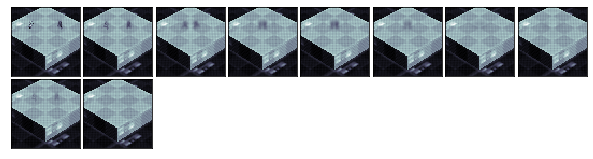

In [0]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the faces, each image is 64 by 64 pixels 
for i in range(10): 
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(temp[i], cmap=plt.cm.bone, interpolation='nearest')

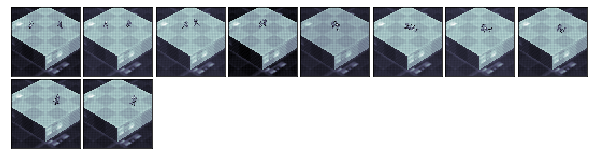

In [0]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(10):
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) 
    ax.imshow(X[i].reshape(64, 64), cmap=plt.cm.bone, interpolation='nearest')